In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID Ïª¨Îüº Î∂ÑÎ¶¨
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
train.head()

ÏÑ§Î¶ΩÏó∞ÎèÑ     Íµ≠Í∞Ä    Î∂ÑÏïº      Ìà¨ÏûêÎã®Í≥Ñ    ÏßÅÏõê Ïàò Ïù∏ÏàòÏó¨Î∂Ä ÏÉÅÏû•Ïó¨Î∂Ä  Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)  Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)  \
0  2009  CT005  Ïù¥Ïª§Î®∏Ïä§  Series A  4126.0   No   No      56.0     3365.0   
1  2023  CT006   ÌïÄÌÖåÌÅ¨      Seed  4167.0  Yes   No      80.0     4069.0   
2  2018  CT007    Í∏∞Ïà†  Series A  3132.0  Yes  Yes      54.0     6453.0   
3  2016  CT006   NaN      Seed  3245.0  Yes  Yes       NaN      665.0   
4  2020  CT002  ÏóêÎìÄÌÖåÌÅ¨      Seed  1969.0   No  Yes      94.0      829.0   

   Ïó∞Îß§Ï∂ú(ÏñµÏõê)  SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)  ÏÑ±Í≥µÌôïÎ•†  
0   4764.0            4.71        NaN   0.3  
1    279.0            1.00  2500-3500   0.8  
2  12141.0            4.00  3500-4500   0.5  
3  10547.0            2.97        NaN   0.7  
4   9810.0            1.00  1500-2500   0.1

In [5]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if 'Ïù¥ÏÉÅ' in val:
        # '6000Ïù¥ÏÉÅ' ‚Üí 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' ‚Üí ÌèâÍ∑†Í∞í Í≥ÑÏÇ∞
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # Ïà´ÏûêÎ°ú Î≥ÄÌôò Í∞ÄÎä•Ìïú Í≤ΩÏö∞
        try:
            return float(val)
        except:
            return None


In [6]:
# ÏÑ§Î¶ΩÏó∞ÎèÑ -> Ïó∞Ï∞®Î°ú Î≥ÄÍ≤Ω
current_year = 2025

train['Ïó∞Ï∞®'] = current_year - train['ÏÑ§Î¶ΩÏó∞ÎèÑ']
test['Ïó∞Ï∞®'] = current_year - test['ÏÑ§Î¶ΩÏó∞ÎèÑ']

# ÏÑ§Î¶ΩÏó∞ÎèÑ Ï†úÍ±∞
train.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)
test.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)

category_features = ['Íµ≠Í∞Ä','Î∂ÑÏïº']
numeric_features = ['Ïó∞Ï∞®', 'Ìà¨ÏûêÎã®Í≥Ñ', 'ÏßÅÏõê Ïàò','Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)','Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)','Ïó∞Îß§Ï∂ú(ÏñµÏõê)','SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)', 'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
bool_features = ['Ïù∏ÏàòÏó¨Î∂Ä','ÏÉÅÏû•Ïó¨Î∂Ä']

# Ìà¨ÏûêÎã®Í≥Ñ ÏàúÏÑúÎ•º Ïà´ÏûêÎ°ú Îß§Ìïë
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# Í≤∞Ï∏°Ïπò Î®ºÏ†Ä Ï≤òÎ¶¨ ÌõÑ Îß§Ìïë
train['Ìà¨ÏûêÎã®Í≥Ñ'] = train['Ìà¨ÏûêÎã®Í≥Ñ'].map(investment_stage_map)
test['Ìà¨ÏûêÎã®Í≥Ñ'] = test['Ìà¨ÏûêÎã®Í≥Ñ'].map(investment_stage_map)

# Í∏∞ÏóÖÍ∞ÄÏπò Î≥ÄÌôò
train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)
test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)

# LabelEncoder Í∞ùÏ≤¥Î•º Í∞Å Î≤îÏ£ºÌòï featureÎ≥ÑÎ°ú Îî∞Î°ú Ï†ÄÏû•ÌïòÏó¨ ÏÇ¨Ïö©
encoders = {}

# Î≤îÏ£ºÌòï Îç∞Ïù¥ÌÑ∞Î•º encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    # train[feature] = train[feature].fillna('Missing')
    # test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# Î∂àÎ¶¨Ïñ∏ Í∞íÏùÑ 0Í≥º 1Î°ú Î≥ÄÌôò ('Yes' ‚Üí 1, 'No' ‚Üí 0 ÏúºÎ°ú Î≥ÄÌôò)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# # ÏàòÏπòÌòï Î≥ÄÏàò Í≤∞Ï∏°ÏπòÎ•º Ï§ëÍ∞ÑÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
# for feature in numeric_features:
#     median_value = train[feature].median()
#     train[feature] = train[feature].fillna(median_value)
#     test[feature] = test[feature].fillna(median_value)

# TabNetÏö© Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏Îç±Ïä§(cat_idxs) Î∞è Ï∞®Ïõê(cat_dims) ÏÑ§Ï†ï
features = [col for col in train.columns if col != 'ÏÑ±Í≥µÌôïÎ•†']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [7]:
import numpy as np

# 1Ïù∏Îãπ ÏßÄÌëú
train['Ìà¨Ïûê_1Ïù∏Îãπ'] = train['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / train['ÏßÅÏõê Ïàò']
train['Îß§Ï∂ú_1Ïù∏Îãπ'] = train['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / train['ÏßÅÏõê Ïàò']

# ÎπÑÏú® ÏßÄÌëú
train['Ìà¨ÏûêÎåÄÎπÑÎß§Ï∂ú'] = train['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (train['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] + 1e-6)  # 0 ÎÇòÎàÑÍ∏∞ Î∞©ÏßÄ
train['Í∞ÄÏπòÎåÄÎπÑÌà¨ÏûêÎπÑÏú®'] = train['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / (train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] + 1e-6)
train['Í≥†Í∞ùÎãπÎß§Ï∂ú'] = train['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (train['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] + 1e-6)

# Ïä§ÏºÄÏùº Î≥ÄÌôò
train['Ïó∞Ï∞®_Î£®Ìä∏'] = np.sqrt(train['Ïó∞Ï∞®'])


In [8]:
test['Ìà¨Ïûê_1Ïù∏Îãπ'] = test['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / test['ÏßÅÏõê Ïàò']
test['Îß§Ï∂ú_1Ïù∏Îãπ'] = test['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / test['ÏßÅÏõê Ïàò']
test['Ìà¨ÏûêÎåÄÎπÑÎß§Ï∂ú'] = test['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (test['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] + 1e-6)
test['Í∞ÄÏπòÎåÄÎπÑÌà¨ÏûêÎπÑÏú®'] = test['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / (test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] + 1e-6)
test['Í≥†Í∞ùÎãπÎß§Ï∂ú'] = test['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (test['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] + 1e-6)
test['Ïó∞Ï∞®_Î£®Ìä∏'] = np.sqrt(test['Ïó∞Ï∞®'])


In [9]:
features += [
    'Ìà¨Ïûê_1Ïù∏Îãπ', 'Îß§Ï∂ú_1Ïù∏Îãπ', 'Ìà¨ÏûêÎåÄÎπÑÎß§Ï∂ú',
    'Í∞ÄÏπòÎåÄÎπÑÌà¨ÏûêÎπÑÏú®', 'Í≥†Í∞ùÎãπÎß§Ï∂ú', 'Ïó∞Ï∞®_Î£®Ìä∏'
]


In [10]:
for df in [train, test]:
    df['Ìà¨Ïûê_ÌöåÏàòÏú®'] = df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] / (df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] + 1e-6)
    df['SNS_ÎÖ∏Ï∂úÎèÑ'] = df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] / (df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] + 1e-6)
    df['SNS_ÏòÅÌñ•Î†•'] = df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] / (df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] + 1e-6)
    df['ÏßÅÏõêÎãπ_Í≥†Í∞ùÏàò'] = df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] / (df['ÏßÅÏõê Ïàò'] + 1e-6)
    df['Ïó∞Îß§Ï∂ú_ÎπÑÏú®'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] + 1e-6)
    df['ÏÑ±Ïû•ÎèÑ'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (df['Ïó∞Ï∞®'] + 1e-6)


In [11]:
features += [
    'Ìà¨Ïûê_ÌöåÏàòÏú®', 'SNS_ÎÖ∏Ï∂úÎèÑ', 'SNS_ÏòÅÌñ•Î†•',
    'ÏßÅÏõêÎãπ_Í≥†Í∞ùÏàò', 'Ïó∞Îß§Ï∂ú_ÎπÑÏú®', 'ÏÑ±Ïû•ÎèÑ'
]


In [12]:
for df in [train, test]:
    df['ÏßÅÏõêÎãπ_Îß§Ï∂ú'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (df['ÏßÅÏõê Ïàò'] + 1e-6)


In [13]:
features += [
    'ÏßÅÏõêÎãπ_Îß§Ï∂ú'
]

In [14]:
# features Î¶¨Ïä§Ìä∏ÏóêÏÑú Ï†úÍ±∞
features = [f for f in features if f not in ['Íµ≠Í∞Ä', 'Î∂ÑÏïº', 'Ìà¨ÏûêÎã®Í≥Ñ']]


In [15]:
features = [f for f in features if f not in ['Ïù∏ÏàòÏó¨Î∂Ä', 'ÏÉÅÏû•Ïó¨Î∂Ä', 'ÏßÅÏõê Ïàò']]


In [16]:
features

['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
 'Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)',
 'Ïó∞Îß§Ï∂ú(ÏñµÏõê)',
 'SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)',
 'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)',
 'Ïó∞Ï∞®',
 'Ìà¨Ïûê_1Ïù∏Îãπ',
 'Îß§Ï∂ú_1Ïù∏Îãπ',
 'Ìà¨ÏûêÎåÄÎπÑÎß§Ï∂ú',
 'Í∞ÄÏπòÎåÄÎπÑÌà¨ÏûêÎπÑÏú®',
 'Í≥†Í∞ùÎãπÎß§Ï∂ú',
 'Ïó∞Ï∞®_Î£®Ìä∏',
 'Ìà¨Ïûê_ÌöåÏàòÏú®',
 'SNS_ÎÖ∏Ï∂úÎèÑ',
 'SNS_ÏòÅÌñ•Î†•',
 'ÏßÅÏõêÎãπ_Í≥†Í∞ùÏàò',
 'Ïó∞Îß§Ï∂ú_ÎπÑÏú®',
 'ÏÑ±Ïû•ÎèÑ',
 'ÏßÅÏõêÎãπ_Îß§Ï∂ú']

In [18]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ (optunaÎäî foldÎ≥¥Îã§ Îπ†Î•∏ Ïã§ÌóòÏóê Ï†ÅÌï©)
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train['ÏÑ±Í≥µÌôïÎ•†'], test_size=0.3, random_state=42
)

# DMatrix Î≥ÄÌôò
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# 1. objective Ìï®Ïàò Ï†ïÏùò
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 13, 15),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'tree_method': 'hist',
        'seed': 42
    }

    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=30,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    return score  # MAEÍ∞Ä ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå!

# 2. study Ïã§Ìñâ
study = optuna.create_study(direction='minimize')  # MAE ÏûëÏùÑÏàòÎ°ù Ï¢ãÏùå
study.optimize(objective, n_trials=300)  # ÏõêÌïòÎäî ÎßåÌÅº ÏãúÎèÑ

# 3. Í≤∞Í≥º ÌôïÏù∏
print("‚úÖ Best trial:")
print(study.best_trial)

[I 2025-04-08 13:33:02,577] A new study created in memory with name: no-name-8452451d-6645-4575-80a8-3b55227356d7
[I 2025-04-08 13:33:02,819] Trial 0 finished with value: 0.20259574734338434 and parameters: {'learning_rate': 0.04078402206829815, 'max_depth': 15, 'subsample': 0.8151159822935873, 'colsample_bytree': 0.679832970977556, 'lambda': 0.08890930124138118, 'alpha': 0.004166875973640952}. Best is trial 0 with value: 0.20259574734338434.
[I 2025-04-08 13:33:03,156] Trial 1 finished with value: 0.203837604792356 and parameters: {'learning_rate': 0.013081585027693032, 'max_depth': 15, 'subsample': 0.7125487189489972, 'colsample_bytree': 0.5215107275745261, 'lambda': 0.0018020836124785302, 'alpha': 0.7090951678763429}. Best is trial 0 with value: 0.20259574734338434.
[I 2025-04-08 13:33:03,360] Trial 2 finished with value: 0.20451817788291504 and parameters: {'learning_rate': 0.09691648650121226, 'max_depth': 14, 'subsample': 0.9085088937314673, 'colsample_bytree': 0.7670345250683335

‚úÖ Best trial:
FrozenTrial(number=198, state=1, values=[0.20022918583778412], datetime_start=datetime.datetime(2025, 4, 8, 13, 34, 34, 451696), datetime_complete=datetime.datetime(2025, 4, 8, 13, 34, 35, 355805), params={'learning_rate': 0.013595053998143234, 'max_depth': 15, 'subsample': 0.82664003985254, 'colsample_bytree': 0.8168889402625412, 'lambda': 0.015493044770611572, 'alpha': 0.002675519712952179}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=15, log=False, low=13, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None)}, trial_id=198, value=None)


In [19]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['ÏÑ±Í≥µÌôïÎ•†']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.013595053998143234,
    'max_depth': 15,
    'subsample': 0.82664003985254,
    'colsample_bytree': 0.8168889402625412,
    'lambda': 0.015493044770611572,
    'alpha': 0.002675519712952179,
    'tree_method': 'hist',
    'seed': 42
}


for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\nüîÅ Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=30,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  üîç Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n‚úÖ Î™®Îì† fold Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
print(f"üìâ ÌèâÍ∑† MAE: {sum(cv_scores)/len(cv_scores):.4f}")



üîÅ Fold 1/10
[0]	train-mae:0.20409	valid-mae:0.20054
[100]	train-mae:0.10365	valid-mae:0.19271
[200]	train-mae:0.05616	valid-mae:0.19151
[266]	train-mae:0.03828	valid-mae:0.19106
  üîç Fold 1 MAE: 0.1910

üîÅ Fold 2/10
[0]	train-mae:0.20302	valid-mae:0.20989
[100]	train-mae:0.10658	valid-mae:0.20050
[200]	train-mae:0.05878	valid-mae:0.19793
[300]	train-mae:0.03354	valid-mae:0.19702
[400]	train-mae:0.01856	valid-mae:0.19635
[459]	train-mae:0.01339	valid-mae:0.19629
  üîç Fold 2 MAE: 0.1963

üîÅ Fold 3/10
[0]	train-mae:0.20312	valid-mae:0.21060
[100]	train-mae:0.10852	valid-mae:0.20707
[109]	train-mae:0.10265	valid-mae:0.20708
  üîç Fold 3 MAE: 0.2071

üîÅ Fold 4/10
[0]	train-mae:0.20389	valid-mae:0.20127
[100]	train-mae:0.10841	valid-mae:0.19680
[179]	train-mae:0.06573	valid-mae:0.19620
  üîç Fold 4 MAE: 0.1962

üîÅ Fold 5/10
[0]	train-mae:0.20311	valid-mae:0.20761
[100]	train-mae:0.10684	valid-mae:0.20289
[188]	train-mae:0.06276	valid-mae:0.20275
  üîç Fold 5 MAE: 0.2028



In [20]:
import xgboost as xgb
import numpy as np

# Ï†ÄÏû•Îêú Î™®Îç∏Îì§Î°ú ÏòàÏ∏°
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ‚Üê Ïó¨Í∏∞Í∞Ä ÌïµÏã¨

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix ÏûÖÎ†•
    predictions_list.append(preds)

# ÌèâÍ∑† ÏòàÏ∏°
final_predictions = np.mean(predictions_list, axis=0)

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
sample_submission['ÏÑ±Í≥µÌôïÎ•†'] = final_predictions
sample_submission.to_csv('./xgboost_new2_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10


In [ ]:
import xgboost as xgb
import numpy as np

# Ï†ÄÏû•Îêú Î™®Îç∏Îì§Î°ú ÏòàÏ∏°
predictions_list = []
weights = []

dtest = xgb.DMatrix(test[features])

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)
    predictions_list.append(preds)

    # MAEÎäî ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏúºÎØÄÎ°ú, Ïó≠ÏàòÎ•º Í∞ÄÏ§ëÏπòÎ°ú ÏÇ¨Ïö©
    weight = 1 / (cv_scores[fold] + 1e-8)  # ÏûëÏùÄ Ïàò ÎçîÌï¥ÏÑú 0 ÎÇòÎàÑÍ∏∞ Î∞©ÏßÄ
    weights.append(weight)

# Í∞ÄÏ§ë ÌèâÍ∑† Í≥ÑÏÇ∞
predictions_array = np.array(predictions_list)
weights_array = np.array(weights)
normalized_weights = weights_array / weights_array.sum()

# weighted average
final_predictions = np.average(predictions_array, axis=0, weights=normalized_weights)

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
sample_submission['ÏÑ±Í≥µÌôïÎ•†'] = final_predictions
sample_submission.to_csv('./xgboost_weighted2_submission.csv', index=False, encoding='utf-8-sig')


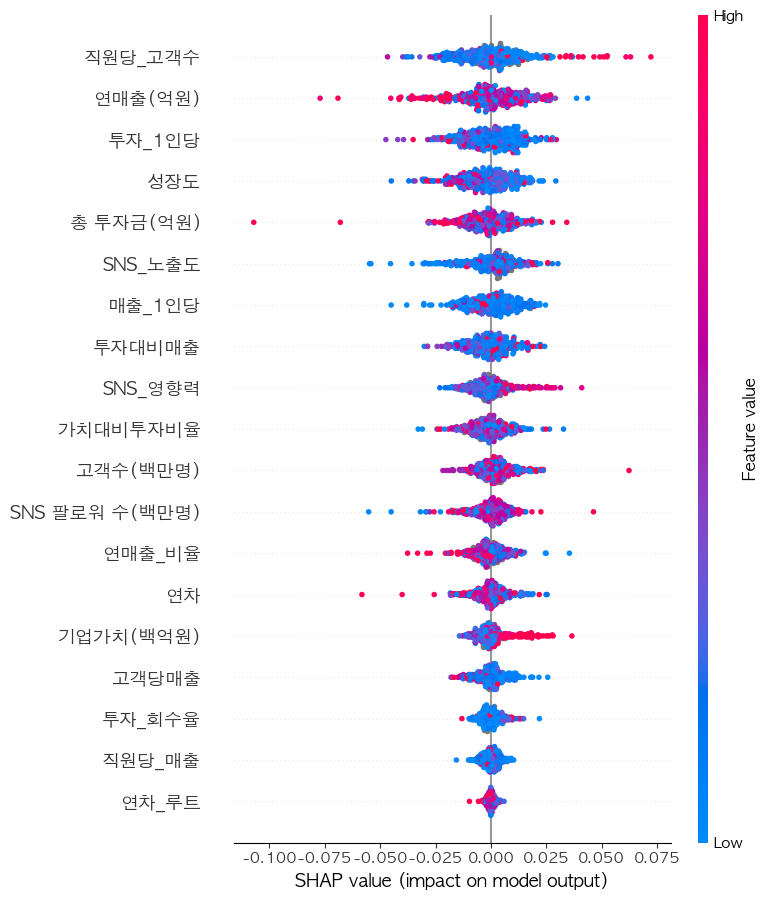

In [22]:
import shap
import matplotlib.font_manager as fm
from collections import defaultdict
import matplotlib.pyplot as plt

# macOS: AppleGothic ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # ÎßàÏù¥ÎÑàÏä§ Íπ®Ïßê Î∞©ÏßÄ

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)
